In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from astropy.cosmology import FlatLambdaCDM

### Cosmology Model

We adopt a **flat ΛCDM cosmology** with parameters  
$H_0 = 70~\mathrm{km\,s^{-1}\,Mpc^{-1}}$ and $\Omega_M = 0.3$.

Distnace modulus is calculated with the help of astropy to save on calculations. 

In [2]:
# ----------------------------------
# Constants & cosmology
# ----------------------------------
H0, OM0   = 70.0, 0.3
LN10  = np.log(10.0)
COSMO = FlatLambdaCDM(H0=H0, Om0=OM0)

def mu_theory(z):
    return COSMO.distmod(z).value

In [3]:
def load_ztf_csv(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=["x0", "x1", "c", "redshift"]).copy()
    return df.reset_index(drop=True)


$
\chi^2 = \sum_i \frac{(\mu_{\text{obs},i} - \mu_{\text{th},i})^2}
               {\sigma_{\mu,i}^2}
\quad
$

$
\mu_{\text{obs}} = -2.5 \log_{10}(x_0) + \alpha x_1 - \beta c + M_B
$

where:
- $x_0$ = amplitude from the SALT2 light-curve fit  
- $x_1$ = stretch parameter  
- $c$ = color parameter  
- $\alpha, \beta, M_B$ are global nuisance parameters.

Partial Derviatives that end up helping out later:

with partial derivatives:
$
\frac{\partial \mu}{\partial x_0} = -\frac{2.5}{x_0 \ln 10}, \quad
\frac{\partial \mu}{\partial x_1} = +\alpha, \quad
\frac{\partial \mu}{\partial c}   = -\beta
$


General Form of the Error Propagation Formula for $y = f(x_1, x_2, \ldots, x_n)$

$
\sigma_y^2 =
\sum_{i=1}^{n}
\left(
\frac{\partial f}{\partial x_i}
\right)^2
\sigma_{x_i}^2
+
\sum_{i \ne j}
2\,
\frac{\partial f}{\partial x_i}
\frac{\partial f}{\partial x_j}
\mathrm{Cov}(x_i, x_j).
$

Using the standard error propagation formula:

$$
\sigma_{\mu,\text{meas}}^2 =
\left(\frac{\partial \mu}{\partial x_0}\right)^2 \sigma_{x_0}^2
+\left(\frac{\partial \mu}{\partial x_1}\right)^2 \sigma_{x_1}^2
+\left(\frac{\partial \mu}{\partial c}\right)^2 \sigma_c^2
+ 2\left(\frac{\partial \mu}{\partial x_0}\frac{\partial \mu}{\partial x_1}\right)\mathrm{Cov}(x_0,x_1)
+ 2\left(\frac{\partial \mu}{\partial x_0}\frac{\partial \mu}{\partial c}\right)\mathrm{Cov}(x_0,c)
+ 2\left(\frac{\partial \mu}{\partial x_1}\frac{\partial \mu}{\partial c}\right)\mathrm{Cov}(x_1,c)
$$


In [4]:
# ----------------------------------
# Error propagation for mu_obs
# ----------------------------------
def sigma_mu_meas2(alpha, beta, x0, x1, c,
                   sig_x0, sig_x1, sig_c,
                   cov_x0_x1, cov_x0_c, cov_x1_c):

    dmu_dx0 = -2.5 / (x0 * LN10)
    dmu_dx1 = +alpha
    dmu_dc  = -beta

    var = (dmu_dx0**2) * (sig_x0**2) \
        + (dmu_dx1**2) * (sig_x1**2) \
        + (dmu_dc**2)  * (sig_c**2)  \
        + 2.0 * (dmu_dx0*dmu_dx1) * cov_x0_x1 \
        + 2.0 * (dmu_dx0*dmu_dc)  * cov_x0_c  \
        + 2.0 * (dmu_dx1*dmu_dc)  * cov_x1_c

    return np.clip(var, 0.0, None)

### Chi-Squared Function with Analytic $M_B$

This function evaluates the chi-squared statistic for the Tripp relation, while solving for the absolute magnitude offset $M_B$ analytically at each trial $(\alpha, \beta)$.


We start out with using astropoy to calcualte the theorateical distance modulus. Then we compute the observed distance modulus (wihtout M_b):

$
   \mu_\ast = -2.5\log_{10}(x_0) + \alpha x_1 - \beta c
$

Then we calculate the measurement variance ($\sigma_{\mu,\text{meas}}^2$) by calling the `sigma_mu_meas2(...)`. 


NOTE: *weights are calculated and clipped to avoid divide-by-zero issues encountered down the line with code!  
This is why $\sigma$ is no longer seen in the equation — computations end up not working out on the Python end, so the equation ends up looking a little bit weird.*


Solve for the best-fit absolute magnitude $M_B^\ast$: 

$
M_B^\ast = 
\frac{\sum_i (\mu_{\mathrm{th},i} - \mu_{\ast,i}) w_i}
      {\sum_i w_i}
$

Then we would compute $\chi^2$:

$
\chi^2 = \sum_i w_i \big[(\mu_{\ast,i} + M_B) - \mu_{\mathrm{th},i}\big]^2,
$

In [5]:
# ----------------------------------
# Chi^2 with analytic M_B (no intrinsic scatter)
# ----------------------------------
def chisq_alpha_beta(theta, z, x0, x1, c,
                     sig_x0, sig_x1, sig_c,
                     cov_x0_x1, cov_x0_c, cov_x1_c):

    alpha, beta = theta

    # Theoretical and observed distance moduli
    mu_th  = mu_theory(z)
    mu_star = -2.5*np.log10(x0) + alpha*x1 - beta*c

    # Measurement variance only (no intrinsic scatter)
    s2 = sigma_mu_meas2(alpha, beta, x0, x1, c,
                        sig_x0, sig_x1, sig_c,
                        cov_x0_x1, cov_x0_c, cov_x1_c)

    # Weight - to make furhter calculations easier to type as code.
    # but also if we do not do the clipping further calcualtions eventually run itno divide-by-zero errors
    w = 1.0 / np.clip(s2, 1e-12, None)


    # Solve for M_B analytically
    MB = np.sum((mu_th - mu_star) * w) / np.sum(w)

    chi2 = np.sum(((mu_star + MB) - mu_th)**2 * w)

    # Cache results for later inspection
    chisq_alpha_beta.last_MB    = MB
    chisq_alpha_beta.last_chi2  = chi2
    chisq_alpha_beta.last_w     = w

    return chi2

# Fit Function #

In [6]:
# ----------------------------------
# Driver
# ----------------------------------
def fit_tripp(csv_path):

    # Lods in the data frame
    df = load_ztf_csv(csv_path)

    # Converts df entries to numpy arrays. Necessary not to throw errors when computing.
    z   = df["redshift"].to_numpy()
    x0  = df["x0"].to_numpy()
    x1  = df["x1"].to_numpy()
    c   = df["c"].to_numpy()

    sig_x0 = df["x0_err"].to_numpy()
    sig_x1 = df["x1_err"].to_numpy()
    sig_c  = df["c_err"].to_numpy()

    cov_x0_x1 = df["cov_x0_x1"].to_numpy()
    cov_x0_c  = df["cov_x0_c"].to_numpy()
    cov_x1_c  = df["cov_x1_c"].to_numpy()

    # scipy.optimize.minimize needs an initial guess in this case its parsed as part of the 
    # minnimiization process. These are complete guesses.
    alpha = 0.14
    beta  = 3.1
    guess = np.array([alpha, beta])


    # So heres what we're inputting into optimize.minimize here:
    # chisq_alpha_beta: the function we want to minimize
    # guess: the initial guess for the parameters we're trying to fit (alpha, beta)
    # args: the arguments that chisq_alpha_beta needs to compute chi^2
    # options: options for the minimization process
    res = optimize.minimize(
        chisq_alpha_beta, guess,
        args=(z, x0, x1, c, sig_x0, sig_x1, sig_c, cov_x0_x1, cov_x0_c, cov_x1_c),
        #options={"maxiter": 5000, "xatol": 1e-8, "fatol": 1e-8}
    )

    alpha_fit, beta_fit = res.x
    MB   = chisq_alpha_beta.last_MB
    chi2_min = chisq_alpha_beta.last_chi2

    out = {
        "alpha": alpha_fit,
        "beta":  beta_fit,
        "MB":    MB,
        "chi2":  chi2_min,
        "number of data points": len(df)
    }
    return out

# ----------------------------------
# Optional: quick test if run as a script
# ----------------------------------
if __name__ == "__main__":
    results = fit_tripp("/Users/pittsburghgraduatestudent/repos/myc21_ztf_mu/ZTF_snia_data.csv")
    print("\nBest-fit parameters:")
    for k, v in results.items():
        print(f"{k:10s}: {v}")


Best-fit parameters:
alpha     : 0.16111228785621984
beta      : 2.640223676180394
MB        : 29.641400568165817
chi2      : 5643101923016.707
number of data points: 3576


<h2><u><span style="color:red;">What about the paper that Michael sent you</span></u></h2>

# Appendix of Information #

<u>Derivation of how we got $M_B$ in the following form:</u>

$
M_B^\ast = 
\frac{\sum_i (\mu_{\mathrm{th},i} - \mu_{\ast,i}) w_i}
      {\sum_i w_i}
$


We are fitting the **Tripp relation**:

$
\mu_{\text{obs}} = -2.5\log_{10}(x_0) + \alpha x_1 - \beta c + M_B,
$

where  
- $x_0, x_1, c$ come from the SALT2 light-curve fit,  
- $\alpha, \beta, M_B$ are global nuisance parameters we want to estimate,  
- $\mu_{\text{th}}(z)$ is the theoretical distance modulus from cosmology.

The chi-squared that we want to minnimize is:

$
\chi^2(\alpha,\beta,M_B)
= \sum_i\frac{\big[\mu_{\text{obs},i}(\alpha,\beta,M_B)- \mu_{\text{th}}(z_i)\big]^2}{\sigma^2_{\mu,i}(\alpha,\beta)}
$


### Define $\mu*$:

$
\mu_* \equiv -2.5\log_{10}x_0 + \alpha x_1 - \beta c.
$

Then  

$
\mu_{\text{obs}} = \mu_* + M_B.
$

We can rewrite the $\chi^2$ equation as:

$
\chi^2(\alpha, \beta, M_B)= \sum_i\frac{\big[(\mu_* + M_B) - \mu_{\text{th}}\big]^2}{\sigma^2_{\mu,i}}.
$

We can solve for $M_B$ analytically by setting

$
\frac{\partial \chi^2}{\partial M_B} = 0.
$

Differentiate:

$
\frac{\partial \chi^2}{\partial M_B}= 2\sum_i \frac{(\mu_* + M_B - \mu_{\text{th}})}{\sigma^2_{\mu,i}} = 0.
$

Solve for $M_B$:

$
M_B =\frac{\sum_i \dfrac{(\mu_{\text{th}} - \mu_*)}{\sigma^2_{\mu,i}}}{\sum_i \dfrac{1}{\sigma^2_{\mu,i}}}
$

Note that in the original expression 1/$\sigma^2$ is simply $w_i$



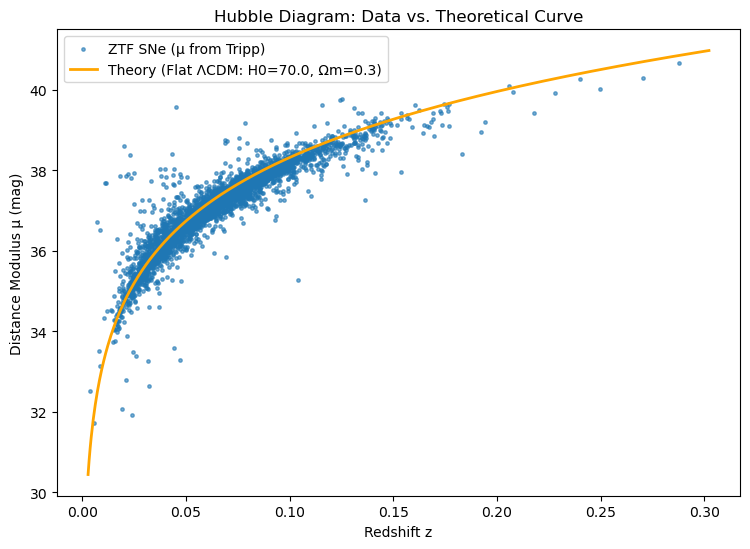

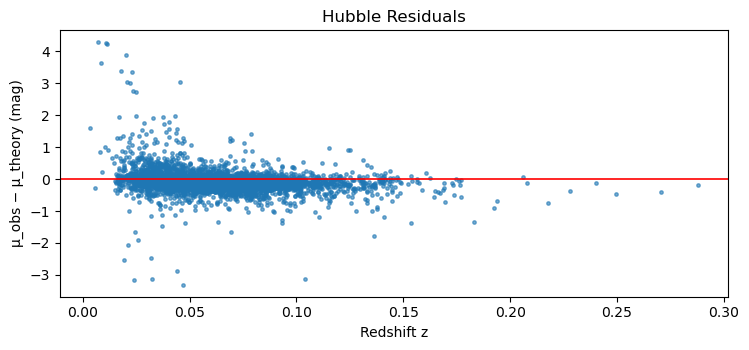

Data points used: 3576
Tripp parameters: alpha=0.161112, beta=2.640224, MB=29.641401
Cosmology: H0=70.0, Omega_M=0.3


In [11]:
# Hubble diagram (data vs theory) + residuals — fixed for "redshift" column

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# -----------------------------
# Settings (edit as needed)
# -----------------------------
CSV_PATH = "/Users/pittsburghgraduatestudent/repos/first_paper_blast_webapi/data_ZTF/ZTF_snia_data.csv"

# Your best-fit Tripp parameters
alpha = 0.16111228785621984
beta  = 2.640223676180394
MB    = 29.641400568165817

# Cosmology for theoretical curve
H0      = 70.0     # km/s/Mpc
Omega_M = 0.3
Tcmb0   = 2.725

# -----------------------------
# Load and clean data
# -----------------------------
df = pd.read_csv(CSV_PATH)
need = ["redshift", "x0", "x1", "c"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"CSV missing required columns: {missing}")
df = df.dropna(subset=need).copy()

redshift = df["redshift"].to_numpy()
x0 = df["x0"].to_numpy()
x1 = df["x1"].to_numpy()
c  = df["c"].to_numpy()

# -----------------------------
# Compute μ_obs (Tripp) and μ_theory
# -----------------------------
mu_obs = -2.5 * np.log10(x0) + alpha * x1 - beta * c + MB

cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_M, Tcmb0=Tcmb0)
mu_th = cosmo.distmod(redshift).value

# Smooth theory curve for plotting
redshift_grid = np.linspace(max(1e-4, redshift.min()*0.8), redshift.max()*1.05, 600)
mu_th_grid = cosmo.distmod(redshift_grid).value

# -----------------------------
# Plot: Hubble diagram
# -----------------------------
plt.figure(figsize=(7.6, 5.6))
plt.scatter(redshift, mu_obs, s=6, alpha=0.6, label="ZTF SNe (μ from Tripp)")
plt.plot(redshift_grid, mu_th_grid, linewidth=2.0, color = "orange", label=f"Theory (Flat ΛCDM: H0={H0}, Ωm={Omega_M})")
plt.xlabel("Redshift z")
plt.ylabel("Distance Modulus μ (mag)")
plt.title("Hubble Diagram: Data vs. Theoretical Curve")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot: residuals (μ_obs − μ_theory)
# -----------------------------
residuals = mu_obs - mu_th
plt.figure(figsize=(7.6, 3.6))
plt.axhline(0.0, color="red", linewidth=1.2)
plt.scatter(redshift, residuals, s=6, alpha=0.6)
plt.xlabel("Redshift z")
plt.ylabel("μ_obs − μ_theory (mag)")
plt.title("Hubble Residuals")
plt.tight_layout()
plt.show()

print(f"Data points used: {len(redshift)}")
print(f"Tripp parameters: alpha={alpha:.6f}, beta={beta:.6f}, MB={MB:.6f}")
print(f"Cosmology: H0={H0}, Omega_M={Omega_M}")